In [73]:
import torch
from tqdm.notebook import tqdm
import numpy as np
from transformer.reimei import ReiMei, ReiMeiParameters
import matplotlib.pyplot as plt
from config import AE_CHANNELS, DIT_S as DIT, MODELS_DIR_BASE, SIGLIP_HF_NAME, SIGLIP_EMBED_DIM
from torch.amp import autocast
from transformers import SiglipTokenizer, SiglipTextModel
from diffusers import AutoencoderDC
import time
import torchvision
from torchvision.transforms import ToPILImage

In [2]:
torch.set_grad_enabled(False)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
embed_dim = 3072
patch_size = (1,1)

params = ReiMeiParameters(
    use_mmdit=True,
    use_ec=True,
    use_moe=None,
    shared_mod=True,
    shared_attn_projs=True,
    channels=AE_CHANNELS,
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_layers=24,
    num_heads=(embed_dim // 128),
    siglip_dim=SIGLIP_EMBED_DIM,
    num_experts=4,
    capacity_factor=2.0,
    shared_experts=1,
    dropout=0.1,
    token_mixer_layers=1,
    image_text_expert_ratio=2,
)
DTYPE = torch.bfloat16

In [6]:
model = ReiMei(params)
model.load_state_dict(torch.load("models/reimei_full_50k.pt")['model_state_dict'])

<All keys matched successfully>

In [7]:
# Print the number of parameters in the model
print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters()))


Number of parameters in the model:  1414251688


In [8]:
siglip_model = SiglipTextModel.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip").to(device)
siglip_tokenizer = SiglipTokenizer.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip")

In [9]:
padded_len = 64


In [77]:
prompts = [
    "beautiful landscape with rolling hills and a cloudy bright blue sky" 
] * 9

In [78]:
t = time.time()

siglip_inputs = []
unpadded_lens = []
for prompt in prompts:
    input = siglip_tokenizer.encode(prompt, return_tensors="pt").to("cuda").squeeze()
    # unpadded_lens.append(input.shape[-1])
    # if input.shape[0] < padded_len:
    #     padding = torch.zeros(padded_len - input.shape[0], dtype=input.dtype, device=input.device)
    #     input = torch.cat([input, padding])
    # else:
    #     input = input[:padded_len]
    siglip_inputs.append(input)

siglip_inputs = torch.stack(siglip_inputs)
siglip_outputs = siglip_model(siglip_inputs, output_hidden_states=True)
siglip_embeddings = siglip_outputs.hidden_states[-1]
siglip_vec = siglip_outputs.pooler_output
print(f"Took: {time.time() - t}")

Took: 0.020025968551635742


In [79]:
siglip_embeddings.shape, 

(torch.Size([9, 13, 1152]),)

In [80]:
# del siglip_model, siglip_tokenizer

In [81]:
print("siglip emb", torch.std_mean(siglip_embeddings))
print("siglip vec", torch.std_mean(siglip_vec))

siglip emb (tensor(1.2209, device='cuda:0'), tensor(0.6818, device='cuda:0'))
siglip vec (tensor(0.6886, device='cuda:0'), tensor(-0.0161, device='cuda:0'))


In [82]:
vae = AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f64c128-mix-1.0-diffusers", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").eval()
# print param count
print(sum(p.numel() for p in vae.parameters()))

676896140


In [83]:
model = model.eval().to(device, dtype=DTYPE)

In [84]:
noise = torch.randn(9, 128, 3, 5).to(device).to(DTYPE)
with torch.inference_mode():
    with autocast("cuda", dtype=DTYPE):
        # pred = model(noise, torch.ones((1,), device="cuda"), siglip_embeddings, siglip_vec, None)
        pred = model.sample(noise, siglip_embeddings, siglip_vec, sample_steps=200, cfg=10.0)

In [85]:
# model = model.to("cpu")
# del model

In [86]:
torch.std_mean(pred)

(tensor(2.6406, device='cuda:0', dtype=torch.bfloat16),
 tensor(0.0273, device='cuda:0', dtype=torch.bfloat16))

In [87]:
vae = vae.to(device)

In [88]:
# model = model.eval()
with autocast("cuda", dtype=DTYPE):
    # pred = model.sample(noise, siglip_embeddings, siglip_vec, sample_steps=50, cfg=7.0)

    pred = vae.decode(pred).sample
    # Change range of pred from x to y to -1 to 1
    min_val = pred.min()
    max_val = pred.max()

    pred = (pred - min_val) / (max_val - min_val)
    pred = 2 * pred - 1

In [89]:
vae = vae.to("cpu")

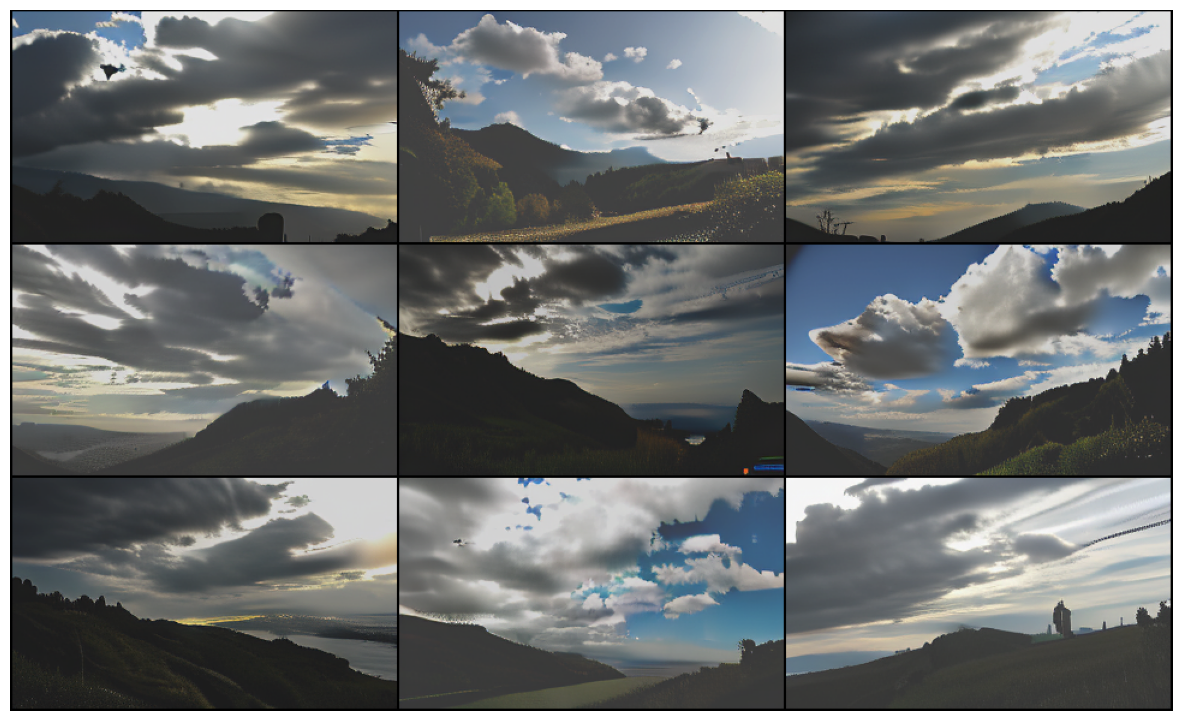

In [93]:
grid = torchvision.utils.make_grid(pred, nrow=3, normalize=True, scale_each=True).to(torch.float16)
img = ToPILImage()(grid)

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()